In [9]:
import sys
!{sys.executable} -m pip uninstall -y stepselector
!{sys.executable} -m pip install --no-deps -U git+https://github.com/BCostelloe/zebra-step-selection --user

Found existing installation: stepselector 0.1
Uninstalling stepselector-0.1:
  Successfully uninstalled stepselector-0.1
  Cloning https://github.com/BCostelloe/zebra-step-selection to /tmp/pip-req-build-e7vzemae
  Running command git clone --filter=blob:none --quiet https://github.com/BCostelloe/zebra-step-selection /tmp/pip-req-build-e7vzemae
  Resolved https://github.com/BCostelloe/zebra-step-selection to commit b069cc4ab6e210dd1b769611dd92da04709fe529
  Preparing metadata (setup.py) ... done
  Created wheel for stepselector: filename=stepselector-0.1-py3-none-any.whl size=15482 sha256=2e9616f62680e96211057d7c2eefb21f623aa5be1fea3d7fcd1b98511bf6ab62
  Stored in directory: /tmp/pip-ephem-wheel-cache-0meici2l/wheels/2f/e1/76/d0f5ae84f935d8f25c11662e99002593204b09182677df40a2
Successfully built stepselector

[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
import sys
sys.path.append('../')

from stepselector.data_loader import ZebraDataset, collate_df
from torch.utils.data import Dataset, DataLoader, Sampler
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.preprocessing import OneHotEncoder
import os
import joblib
from osgeo import gdal
from tqdm.notebook import tqdm

gdal.UseExceptions()

In [2]:
import os
import pandas as pd

# Specify radius (in meters) to define social density (number of conspecifics within radius)
social_radius = 10

# How many fake steps to use per real step? (max 20)
num_ref_steps = 10
num_context_steps = 5

# Define data directories
server_mount = '/media/herd_hover'
data_folder = os.path.join(server_mount, 'zebra_movement_data')
step_length = 'five'  # Options: 'five', 'ten'

observed_steps_directory = os.path.join(data_folder, f'{step_length}_meter_steps', 'observed')
simulated_steps_directory = os.path.join(data_folder, f'{step_length}_meter_steps', 'simulated')
track_metadata_file = os.path.join(data_folder, 'track_metadata.csv')

# All available features
# all_features = [
#    'target_id',
#    'observation',
#    'step_speed_mps',
#    'angle_to_observers', 
#    'dist_to_observer', 
#    'delta_observer_dist', 
#    'road', 
#    'ground_class', # all ground classes
#    'ground_bare',
#    'ground_tree',
#    'ground_grass'
#    'ground_slope', 
#    'viewshed_vis', 
#    'social_dens', 
#    'social_vis',
#    'age_class',
#    'species',
#    'individual_ID',
# ]

# Define feature sets for the dataloader
context_features = [
    'viewshed_vis', 
    'step_speed_mps',
    'angle_to_observers', 
    'road', 
    'ground_class', # all ground classes
    # 'ground_bare',
    # 'ground_tree',
    'ground_slope', 
    'social_dens', 
    'social_vis',
]

target_features = [
    'viewshed_vis', 
    'step_speed_mps',
    'angle_to_observers', 
    'road', 
    'ground_class', # all ground classes
    # 'ground_bare',
    # 'ground_tree',
    'ground_slope', 
    'social_dens', 
    'social_vis',
    # 'species',
    # 'age_class',
    # 'individual_ID',
]

# Initialize dataset
dataset = ZebraDataset(
    target_dir=observed_steps_directory,
    reference_dir=simulated_steps_directory,
    social_radius=social_radius,
    num_ref_steps=num_ref_steps,
    num_context_steps=num_context_steps,
    context_features=context_features,
    target_features=target_features
)

# Initialize a new dataset instance for extracting raw features
dataset_raw_features = ZebraDataset(
    target_dir=observed_steps_directory,
    reference_dir=simulated_steps_directory,
    social_radius=social_radius,
    num_ref_steps=num_ref_steps,
    num_context_steps=num_context_steps,
    use_transformed=False,  # Get raw features
    return_dataframe=True,   # Return as DataFrame
    context_features=context_features,
    target_features=target_features
)

dataset_transformed_features = ZebraDataset(
    target_dir=observed_steps_directory,
    reference_dir=simulated_steps_directory,
    social_radius=social_radius,
    num_ref_steps=num_ref_steps,
    num_context_steps=num_context_steps,
    use_transformed=True,  # Get transformed features
    return_dataframe=True,   # Return as DataFrame
    context_features=context_features,
    target_features=target_features
)

/tmp/ipykernel_1732901/1096158353.py:73: UserWarning: NaN values detected in target_df. These rows will be dropped.
  dataset = ZebraDataset(
/tmp/ipykernel_1732901/1096158353.py:84: UserWarning: NaN values detected in target_df. These rows will be dropped.
  dataset_raw_features = ZebraDataset(
/tmp/ipykernel_1732901/1096158353.py:96: UserWarning: NaN values detected in target_df. These rows will be dropped.
  dataset_transformed_features = ZebraDataset(


In [3]:
# Create DataLoader
dataloader = DataLoader(dataset, batch_size=10)
# Iterate through the DataLoader
for batch in dataloader:
    target, references, context = batch
    break  # Exit after the first batch

In [4]:
target.shape, references.shape, context.shape

(torch.Size([10, 1, 11]), torch.Size([10, 10, 1, 11]), torch.Size([10, 5, 11]))

In [5]:
print(len(context[0]) == num_context_steps)

True


In [6]:
import torch
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm

def extract_features(dataloader_features):
    """
    Extract original input features for target, context, and reference steps.
    
    Args:
        dataloader_features: DataLoader providing original input features as DataFrames.
    
    Returns:
        features_dict: Dictionary containing input features as Pandas DataFrames.
    """
    features_dict = {
        "target": [],
        "context": [],
        "reference": []
    }
    
    for target_feat, reference_feat, context_feat in tqdm(dataloader_features, desc="Extracting Features"):
        # Store original features as DataFrames
        features_dict["target"].append(target_feat)
        features_dict["context"].append(context_feat)
        features_dict["reference"].append(reference_feat)
    
    # Concatenate DataFrames
    features_dict["context"] = pd.concat(features_dict["context"], ignore_index=True)
    features_dict["target"] = pd.concat(features_dict["target"], ignore_index=True)
    features_dict["reference"] = pd.concat(features_dict["reference"], ignore_index=True)
    
    return features_dict

# Example usage
batch_size = 128
dataloader_features = DataLoader(dataset_raw_features, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=8, collate_fn=collate_df)
features = extract_features(dataloader_features)


Extracting Features: 100%|██████████████████████| 48/48 [00:06<00:00,  7.45it/s]


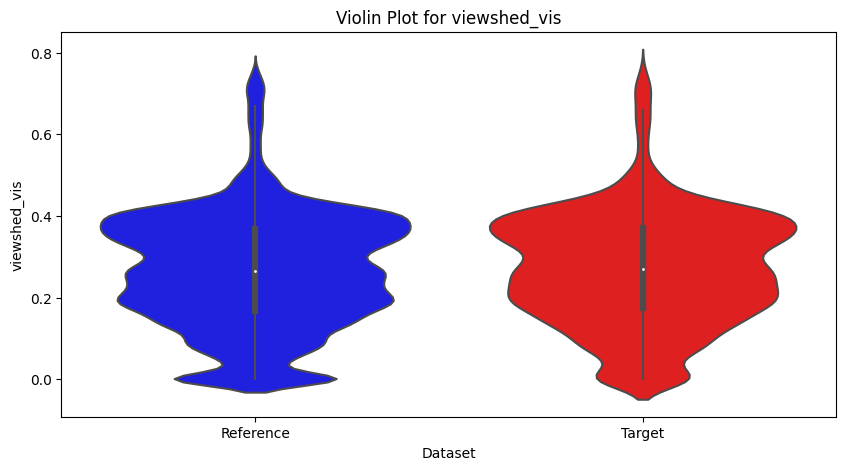

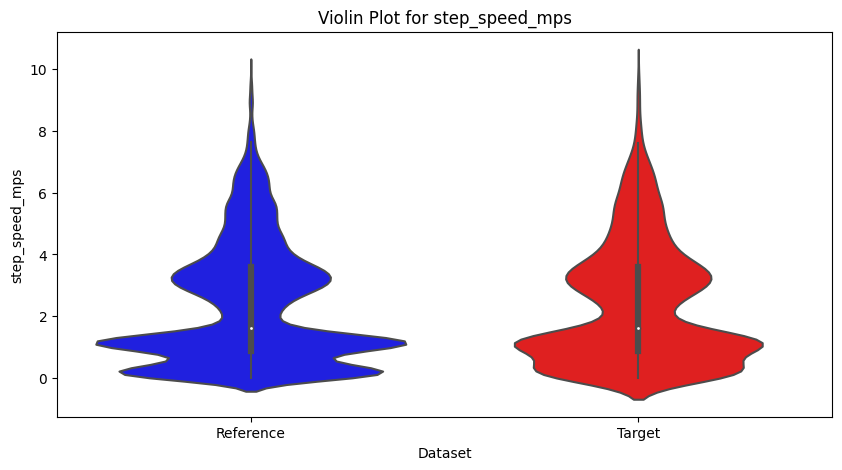

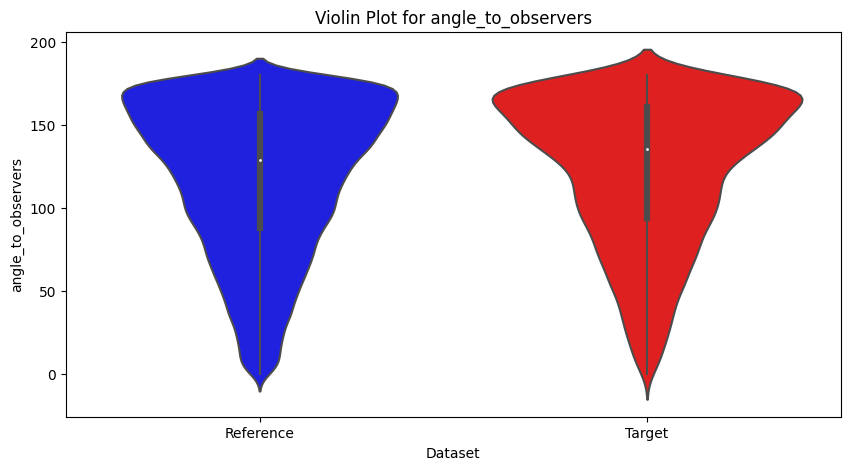

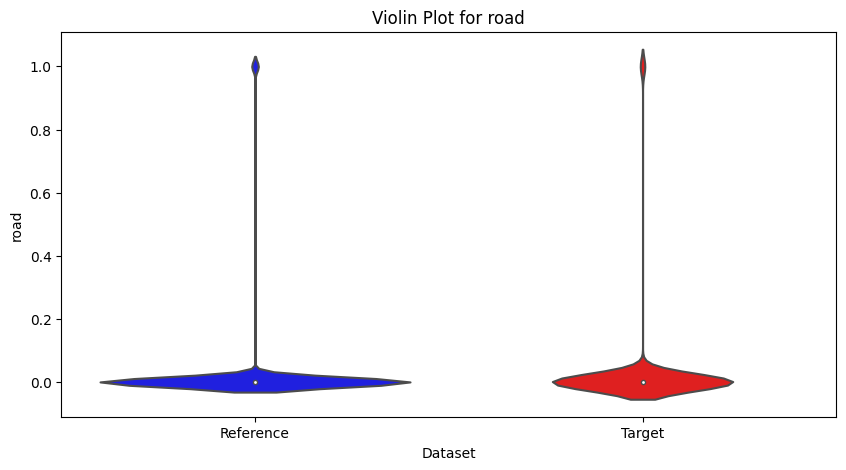

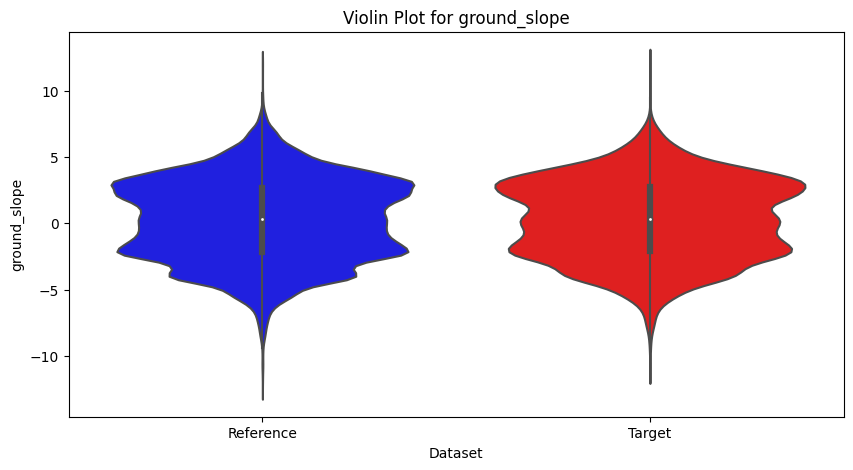

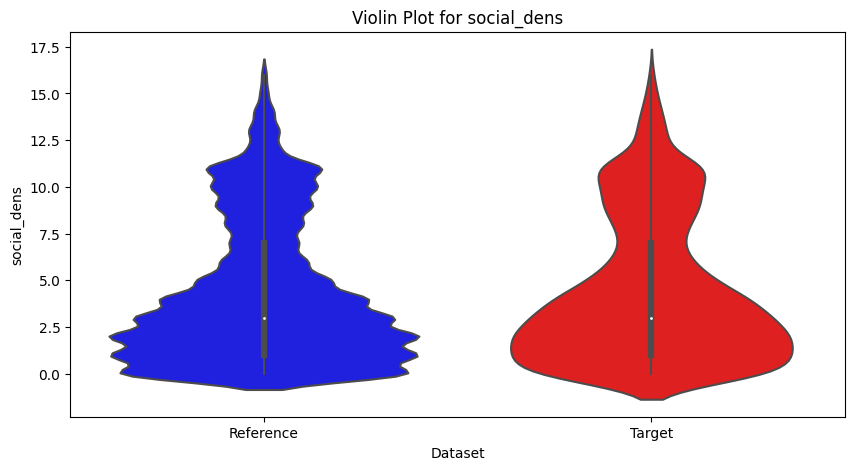

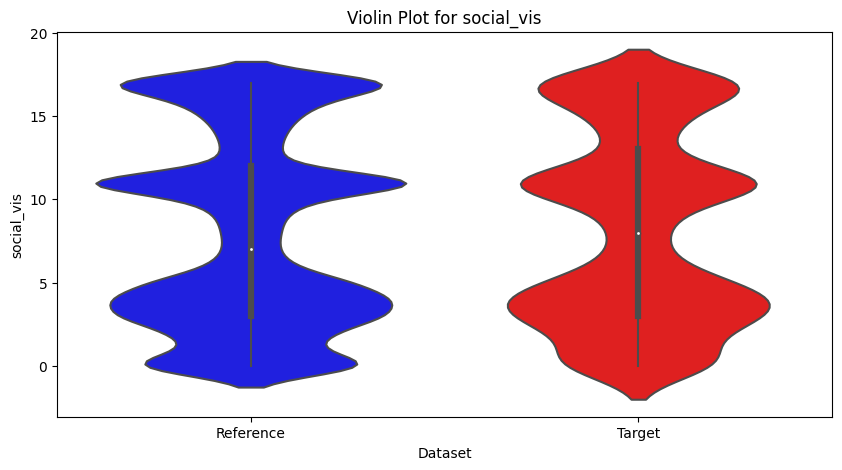

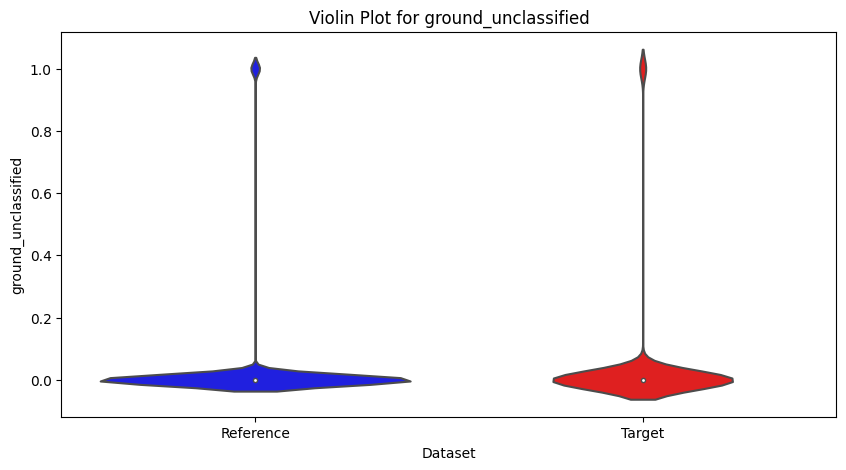

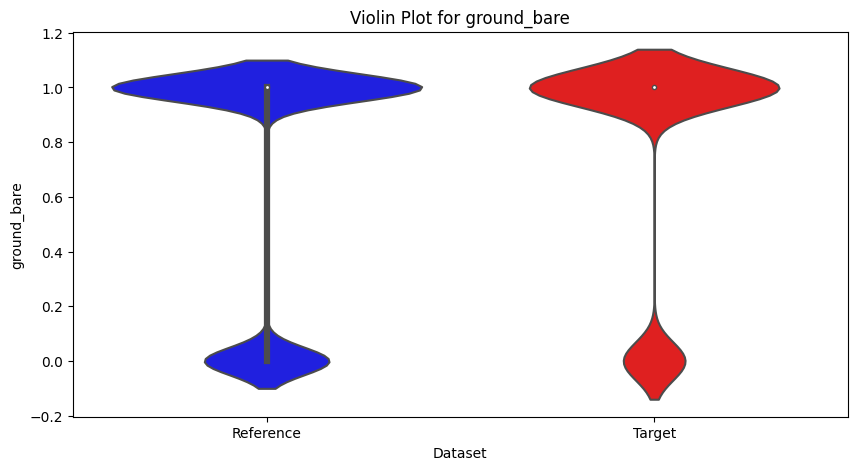

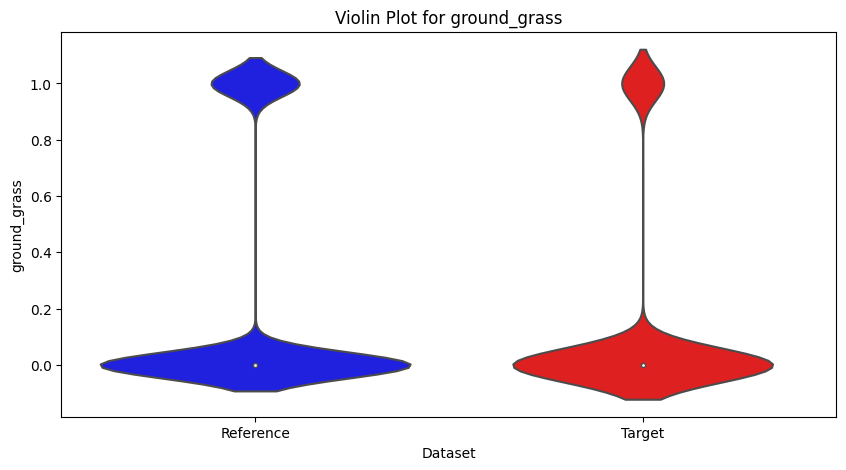

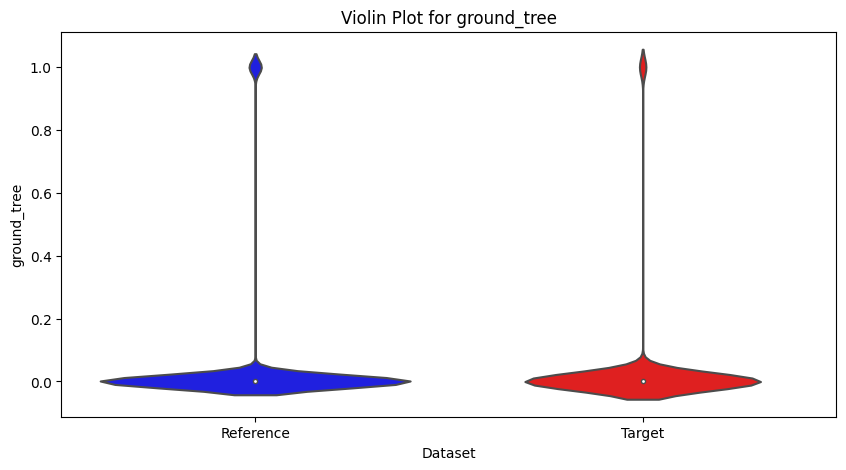

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the common columns from both reference and target datasets
common_columns = features["reference"].columns.intersection(features["target"].columns)

# Iterate through each common column to create a violin plot
for col in common_columns:
    plt.figure(figsize=(10, 5))
    sns.violinplot(
        data=[
            features["reference"][col].dropna(),
            features["target"][col].dropna()
        ],
        palette=["blue", "red"]
    )
    plt.xticks(ticks=[0, 1], labels=["Reference", "Target"])
    plt.title(f'Violin Plot for {col}')
    plt.xlabel('Dataset')
    plt.ylabel(col)
    plt.show()


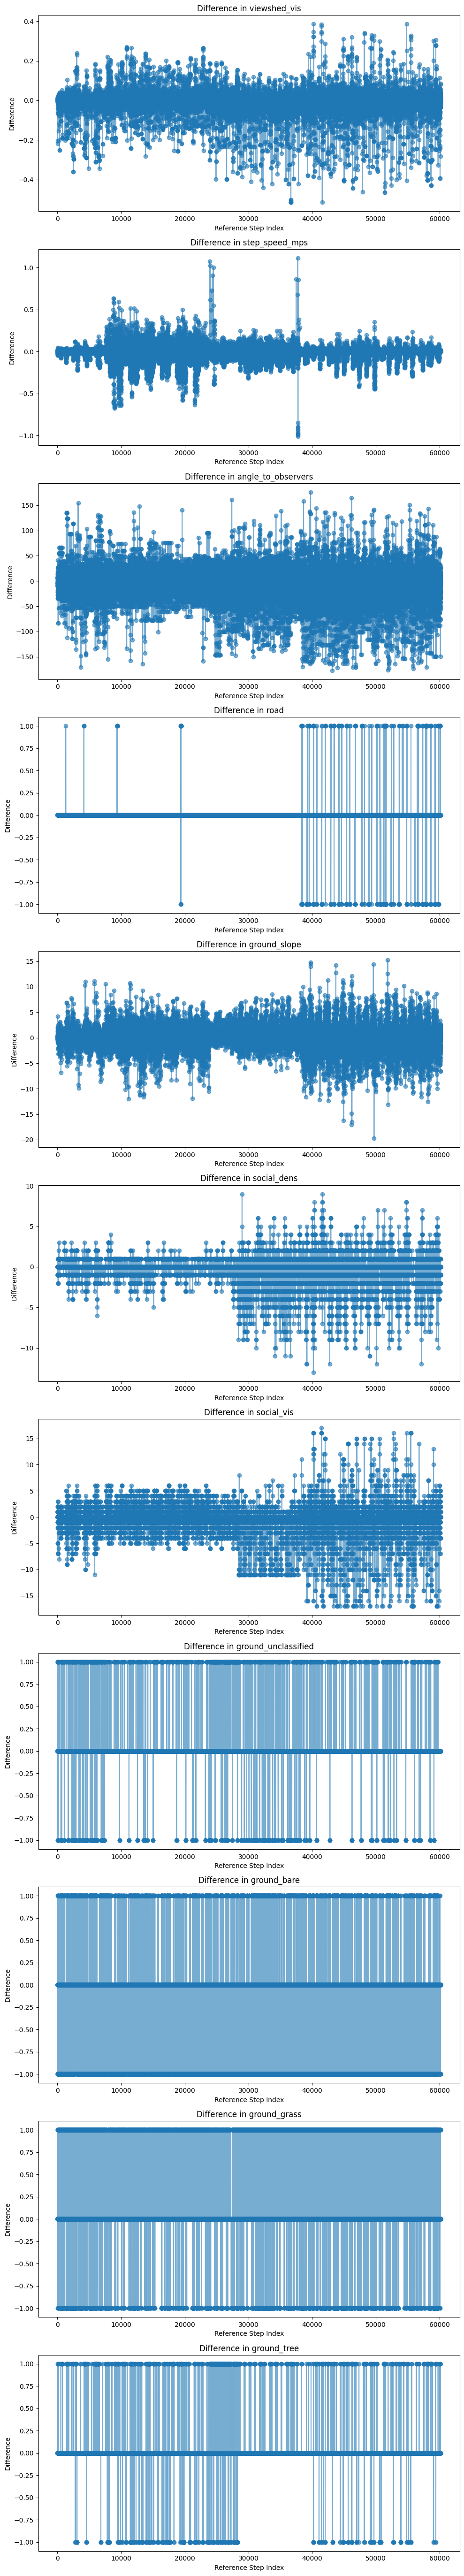

In [8]:
import matplotlib.pyplot as plt

def plot_feature_differences(features_dict, num_ref_steps):
    """
    Compute and plot the difference between target and reference steps.

    Args:
        features_dict: Dictionary containing input features as Pandas DataFrames.
        num_ref_steps: Number of reference steps per target row.
    """
    # Extract target and reference features
    target_df = features_dict["target"]
    reference_df = features_dict["reference"]

    # Ensure the reference dataframe has a number of rows that is a multiple of target rows
    assert len(reference_df) % len(target_df) == 0, "Reference steps do not align with target steps correctly."

    # Compute differences by aligning each target row with its reference rows
    differences = []
    for i, target_row in target_df.iterrows():
        ref_rows = reference_df.iloc[i * num_ref_steps: (i + 1) * num_ref_steps]
        diff = ref_rows.subtract(target_row, axis=1)  # Subtract target from each reference step
        differences.append(diff)

    # Concatenate all differences
    differences_df = pd.concat(differences, ignore_index=True)

    # Plot differences for each feature
    num_features = differences_df.shape[1]
    fig, axes = plt.subplots(nrows=num_features, figsize=(10, 5 * num_features))

    if num_features == 1:
        axes = [axes]  # Ensure axes is iterable

    for i, column in enumerate(differences_df.columns):
        axes[i].plot(differences_df[column], marker="o", linestyle="-", alpha=0.6)
        axes[i].set_title(f"Difference in {column}")
        axes[i].set_xlabel("Reference Step Index")
        axes[i].set_ylabel("Difference")

    plt.tight_layout()
    plt.show()

# Generate and plot feature differences
plot_feature_differences(features, num_ref_steps)
